## Supply Chain Analytics

---
##### About PuLP
#### PuLP — a Python library for linear optimization
There are many libraries in the Python ecosystem for this kind of optimization problems. PuLP is an open-source linear programming (LP) package which largely uses Python syntax and comes packaged with many industry-standard solvers. It also integrates nicely with a range of open source and commercial LP solvers.

---
##### The problem we'll be solving today in Python

A company produces 4 products (named A, B, C, and D) at their factory and transports the products to a terminal by vessel.
There are 4 vessels available, which are paid per trip (from plant to terminal).
Capacities and costs are given.

At the terminal, the products are stored in silos. Silo space for each product is given, along with the intial inventory levels.

Forecasted demand at the terminal for the next 8 weeks is given and must be satisfied.
At the terminal, there is a calculated inventory holding cost per ton per week.
 

- a)	Try to find a transportation plan that minimises the sum of vessel costs and inventory holding costs.  

- b)	Try to find a transportation plan that maximises total profit defined as total value of the cargo transported to the terminal minus vessel costs and inventory holding costs. 

- c)	Try to find a transportation plan that maximises total profit if at most 2 vessels can be used per week. 

- d)	Try to find a transportation plan that maximises total profit if at most 2 vessels can be used per week and each vessel can carry at most two different products in any given week due to limited number of cargo holds onboard the vessels. 

- e)	Try to find a transportation plan that maximises total profit under the same assumptions as in d). However, assume that there are also restrictions on the minimum quantities of each product that can be transported.


### DATA

set PRODUCT := A B C D;
set VESSEL := Apollo Boreas Castor Doris;
param T := 8;
param demand: 
		1		2		3		4		5		6		7		8	:=
	A	7000	8000	11000	12000	11000	12000	11000	10000				
	B	5000	7000	8000	7000	5000	4000	11000	12000
	C	2000	7000	5000	3000	4000	3000	2000	5000				
	D	4000	1000	2000	7000	7000	5000	7000	8000;
param value := 		A 165	B 125 	C 130	D 240;
param h := 			A 5		B 3		C 4		D 6;
param tripcost :=	Apollo	1000000	Boreas	850000	Castor	760000	Doris	620000;
param initinv := 	A 3700	B 6500 	C 4200	D 5500;
param invcap := 	A 8000	B 6500	C 7500	D 7000;
param vesselcap :=  Apollo	19000	Boreas	13500	Castor	11000	Doris	8500;
param minQ :=   	Apollo	8000	Boreas	6000	Castor	4500	Doris	3500;

### Mathematical Folumation 

$ maximize (Sumvalue - Sumvesselcosts - suminvcosts) $

$s.t. I_{i,1} = initinv_{i} + \sum_{v\in VESSEL}(X_{i,v,1}) - demand_{i,1} \forall i \in PRODUCT$

$s.t. I_{i,t} = I_{i,t-1} + \sum_{v\in VESSEL}(X_{i,v,t}) - demand_{i,t} \forall i \in PRODUCT, t \in 2..T$

$s.t. \sum_{i \in PRODUCT}(X_{i,v,t}) \leq vesselcap_{v}*USE_{v,t} \forall v \in VESSEL, t \in 1..T$

$s.t. I_{i,t} \leq invcap_{i} \forall i \in PRODUCT, t \in 1..T$

$Sumvalue = \sum_{i \in PRODUCT}\sum_{v \in VESSEL}\sum_{t \in 1..T}X_{i,v,t}*value_{i}$

$Sumvesselcosts = \sum_{v \in VESSEL}\sum_{t \in 1..T}USE_{v,t}*tripcost_{v}$

$Suminvcosts = \sum_{v \in VESSEL}\sum_{t \in 1..T}I_{i,t}*h_{i}$

$Cargo_{v,t} = \sum_{i \in PRODUCT}X_{i,v,t} \forall v \in VESSEL, t \in 1..T$

$ X_{i,v,t} \leq vesselcap_{v}*Y_{i,v,t} \forall i \in PRODUCT,v \in VESSEL, t \in 1..T$ 

$\sum_{i \in PRODUCTS}Y_{i,v,t} \leq 2 \forall v \in VESSEL, t \in 1..T$

$\sum_{v \in VESSEL}USE_{v,t} \leq 2 \forall t \in 1..T$

$X_{i,v,t} \geq minQ_{v}*Y_{i,v,t} \forall i \in PRODUCT,v \in VESSEL, t \in 1..T$ 

### Explanation of the Obj. funtion and the constraints:
- Maximize total profit
- Define Inventory level for each product at time 1
- Define the inventory level for each product from time 2 and onward
- Define the tranportation capacity contraint for each vessel at each time period and force it to be zero if the vessel is not being used.
- Inventory level for each product at each time period can not exceed the inventory capacity
- The Sumvalue is the total quantity transported by the vessels during the time period, multiplied with their according value
- Vessel costs is the product of vessel trips over the period and the according trip cost
- Inventory costs is the product between the total inventoty that has been stored over the period and the inventory cost
- Here we make the variable Cargo to represent to the total amount transported by each vessel at each time period. It is for the purpose of analysis. Not constraining the model.
- This constraint connect variable Y and X, thus forces X to be zero if the model decides to make variable Y zero 
- At most two products can be transported in each time period by a vessel
- At most 2 vessels can be used in each time period
- If a transportation of products is happening then it shall be at least a given minimum amount for each vessel

---
### The AMPL Model

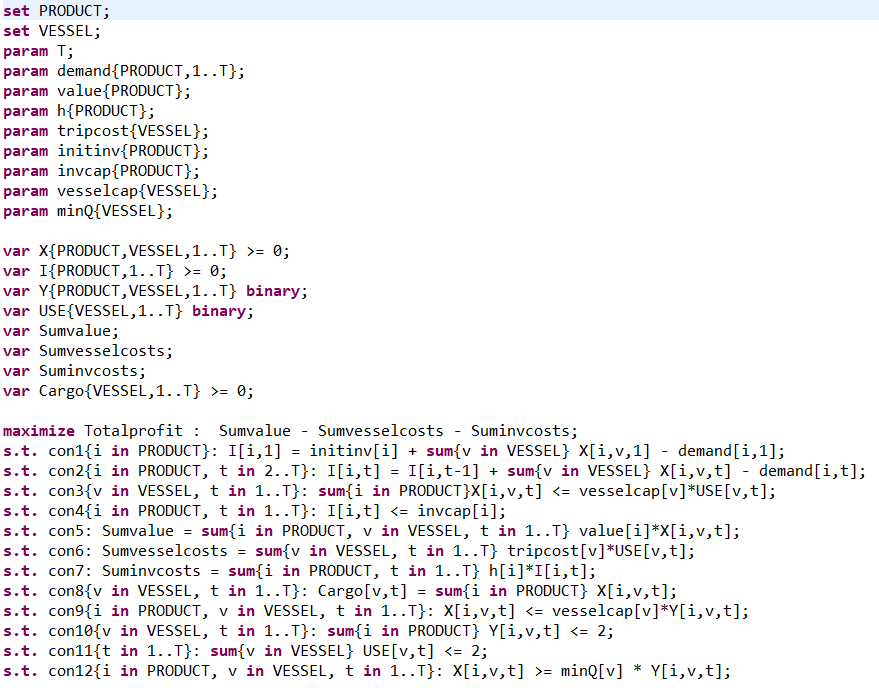

## Installation of PuLP
The easiest way to install pulp is via PyPi

#### If pip is available on your system:

- pip install pulp
---

### To install this package with conda run one of the following:
- conda install -c conda-forge pulp
- conda install -c conda-forge/label/broken pulp
- conda install -c conda-forge/label/cf201901 pulp
- conda install -c conda-forge/label/cf202003 pulp

In [1]:
# Import Packages
import pulp as plp
import numpy as np
import pandas as pd

In [2]:
# Data
PRODUCT = ['A','B','C','D']
VESSEL = ['Apollo','Boreas','Castor','Doris']
T = 8
matrix = np.reshape((7000,8000,11000,12000,11000,12000,11000,10000,
                    5000,7000,8000,7000,5000,4000,11000,12000,
                    2000,7000,5000,3000,4000,3000,2000,5000,
                    4000,1000,2000,7000,7000,5000,7000,8000), (4, 8))
demand = pd.DataFrame(matrix, columns=range(T), index=PRODUCT)

value = {'A':165,'B':125,'C':130,'D':240}
h = {'A':5,'B':3,'C':4,'D':6}
initinv = {'A':3700,'B':6500,'C':4200,'D':5500}
invcap = {'A':8000,'B':6500,'C':7500,'D':7000}
vesselcap = {'Apollo':19000,'Boreas':13500,'Castor':11000,'Doris':8500}
minQ = {'Apollo':8000,'Boreas':6000,'Castor':4500,'Doris':3500}
tripcost = {'Apollo':1000000,'Boreas':850000,'Castor':760000,'Doris':620000}

In [13]:
def Supply_Chain_Optim(PRODUCT,VESSEL,T,demand,value,h,tripcost,initinv,vesselcap,minQ):
    
    # Define type of problem:
    prob = plp.LpProblem('Supply_Chain',plp.LpMaximize)
    
    # Define Variables:
    X = plp.LpVariable.dicts("X",
                             ((i,v,t) for i in PRODUCT for v in VESSEL for t in range(T)),
                             lowBound=0,cat="Continuous")
    I = plp.LpVariable.dicts("I",
                             ((i,t) for i in PRODUCT for t in range(T)),
                             lowBound=0,cat="Continuous")
    Y = plp.LpVariable.dicts("Y",
                             ((i,v,t) for i in PRODUCT for v in VESSEL for t in range(T)),
                             lowBound=0,
                             cat=plp.LpBinary)
    USE = plp.LpVariable.dicts("USE",
                               ((v,t) for v in VESSEL for t in range(T)),
                               lowBound=0,
                               cat=plp.LpBinary)
    Cargo = plp.LpVariable.dicts("Cargo",
                             ((v,t) for v in VESSEL for t in range(T)),
                             lowBound=0,cat="Continuous")
    Sumvalue = plp.LpVariable("Sumvalue",lowBound=0)
    Sumvesselcosts = plp.LpVariable("Sumvesselcosts",lowBound=0)
    Suminvcosts = plp.LpVariable("Suminvcosts",lowBound=0)
    
    # Define the Objective Function:
    prob += (Sumvalue - Sumvesselcosts - Suminvcosts)
    
    # Define the Constraints:
    # con1:
    for i in PRODUCT:
        prob += I[i,0] == initinv[i] + plp.lpSum([X[i,v,0] for v in VESSEL]) - demand.loc[i,0] 
    
    # con2:
    for i in PRODUCT:
        for t in range(1,T):
            prob += I[i,t] == I[i,t-1] + plp.lpSum([X[i,v,t] for v in VESSEL]) - demand.loc[i,t]
    
    # con3:
    for v in VESSEL:
        for t in range(T):
            prob += plp.lpSum([X[i,v,t] for i in PRODUCT]) <= vesselcap[v]*USE[v,t]
            
    # con4:
    for i in PRODUCT:
        for t in range(T):
            prob += I[i,t] <= invcap[i]
            
    # con5:
    prob += plp.lpSum([value[i]*X[i,v,t] for t in range(T) for v in VESSEL for i in PRODUCT]) == Sumvalue 
    
    # con6:
    prob += plp.lpSum([tripcost[v]*USE[v,t] for t in range(T) for v in VESSEL]) == Sumvesselcosts
    
    # con7:
    prob += plp.lpSum([h[i]*I[i,t] for t in range(T) for i in PRODUCT]) == Suminvcosts
    
    # con8:
    for v in VESSEL:
        for t in range(T):
            prob += plp.lpSum([X[i,v,t] for i in PRODUCT]) == Cargo[v,t]
    
    # con9:
    for i in PRODUCT:
        for v in VESSEL:
            for t in range(T):
                prob += vesselcap[v]*Y[i,v,t]  >= X[i,v,t] 
    
    # con10:
    for v in VESSEL:
        for t in range(T):
            prob += plp.lpSum([Y[i,v,t] for i in PRODUCT]) <= 2
    
    # con11:
    for t in range(T):
        prob += plp.lpSum([USE[v,t] for v in VESSEL]) <= 2
    
    # con12:
    for i in PRODUCT:
        for v in VESSEL:
            for t in range(T):
                prob += minQ[v]*Y[i,v,t]  <= X[i,v,t] 
    
    # Solve 
    #prob.solve()
    prob.solve(plp.GUROBI(msg=True)) 
    print(plp.LpStatus[prob.status])
    
    the_X = np.array([[[X[(i,v,t)].varValue for v in VESSEL ]for t in range(T)] for i in PRODUCT])
    #the_Y = np.array([[[Y[i,v,t].varValue for i in PRODUCT] for v in VESSEL] for t in range(T)])
    #the_USE = np.array([[USE[v,t].varValue for v in VESSEL] for t in range(T)])
    the_Cargo = np.array([[Cargo[v,t].varValue for v in VESSEL] for t in range(T)])

    result = Sumvalue.varValue - Sumvesselcosts.varValue - Suminvcosts.varValue
    
    return 'Result: ',result,'Sumvalue: ',Sumvalue.varValue,'Sumvesselcosts: ', Sumvesselcosts.varValue,'Suminvcosts: ', Suminvcosts.varValue, 'X:', np.round(the_X,1), 'Cargo:', np.round(the_Cargo,1)

In [14]:
Supply_Chain_Optim(PRODUCT,VESSEL,T,demand,value,h,tripcost,initinv,vesselcap,minQ)

Gurobi status= 2
Optimal


('Result: ',
 22575300.0,
 'Sumvalue: ',
 35636000.0,
 'Sumvesselcosts: ',
 12490000.0,
 'Suminvcosts: ',
 570700.0,
 'X:',
 array([[[    0.,     0.,     0.,  3700.],
         [ 8600.,     0.,     0.,     0.],
         [11000.,     0.,     0.,     0.],
         [11000.,     0.,     0.,     0.],
         [19000.,     0.,     0.,     0.],
         [ 9400.,     0.,     0.,     0.],
         [    0., 13500.,     0.,     0.],
         [10100.,     0.,     0.,     0.]],
 
        [[    0.,     0.,     0.,     0.],
         [10400.,     0.,     0.,     0.],
         [   -0.,     0.,     0.,  5000.],
         [ 8000.,     0.,     0.,     0.],
         [    0.,  6100.,     0.,     0.],
         [    0.,  6500.,     0.,     0.],
         [11000.,     0.,     0.,     0.],
         [ 8900.,     0.,     0.,     0.]],
 
        [[    0.,     0.,     0.,  4800.],
         [    0.,     0.,     0.,     0.],
         [ 8000.,     0.,     0.,     0.],
         [    0.,  7500.,     0.,     0.],
         [

# Individual Academic Licenses for Gurobi Solver:
### - Named-user academic license: 
This license can be set up on a single physical machine. Users may install and license Gurobi for their own use on more than one machine.
### - To obtain this license:
- After registering and logging in, visit the Download Gurobi Optimizer page( https://www.gurobi.com/downloads/ ), and download the version you need, as well as the README.txt.
- After downloading, visit the Free Academic License page( https://www.gurobi.com/downloads/end-user-license-agreement-academic/ ) to request the free license.
- Follow the instructions in README.txt to install the software.
- Once installed, run ‘grbgetkey’ using the argument provided (ex: grbgetkey ae36ac20-16e6-acd2-f242-4da6e765fa0a). The ‘grbgetkey’ program will prompt you to store the license file on your machine.
---

### To install the Gurobi package into Anaconda. 
You do this by first adding the Gurobi channel into your Anaconda platform and then installing the gurobi package from this channel. From an Anaconda terminal issue the following command to add the Gurobi channel to your default search list:

- conda config --add channels http://conda.anaconda.org/gurobi

#### Now issue the following command to install the Gurobi package:

- conda install gurobi
- (you can also try : conda install -c gurobi gurobi)
---

## Using pip to install gurobipy
Most Python installations come with the Python package management system “pip”. You can use pip to download and install the gurobipy extension simply by opening a terminal window and issuing the following command:

- python -m pip install -i https://pypi.gurobi.com gurobipy

In [8]:
import gurobipy as gb

In [9]:
# SAME PROBLEM WITH THE GUROBI PACKAGE
def Supply_Chain_Optim_GB(PRODUCT,VESSEL,T,demand,value,h,tripcost,initinv,vesselcap,minQ):     
    
    # Initiate optimization model
    model = gb.Model("Optimize Supply Chain")

    # DEFINE VARIABLES
    # Variable 
    X = model.addVars(PRODUCT, VESSEL, T, lb=0, vtype=gb.GRB.CONTINUOUS, name="X")
    Y = model.addVars(PRODUCT, VESSEL, T, vtype=gb.GRB.BINARY, name="Y")
    I = model.addVars(PRODUCT, T,lb=0,vtype=gb.GRB.CONTINUOUS,name="I")
    USE = model.addVars(VESSEL, T, vtype=gb.GRB.BINARY, name="USE")
    Cargo = model.addVars(VESSEL,T,vtype=gb.GRB.CONTINUOUS,name='Cargo')
    
    Sumvalue = model.addVar(name="Sumvalue",lb=0)
    Sumvesselcosts = model.addVar(name="Sumvesselcosts",lb=0)
    Suminvcosts = model.addVar(name="Suminvcosts",lb=0)

    # Constraints
    model.addConstrs((I[(i,0)] == initinv[i] + X.sum(i,'*',0) - demand.loc[i,0]
        for i in PRODUCT),name="con1")
    
    model.addConstrs((I[(i,t)] == I[(i,t-1)] + X.sum(i,'*',t) - demand.loc[i,t]
        for i in PRODUCT
        for t in range(1,T)),name="con2")
    
    model.addConstrs((X.sum('*',v,t) <= vesselcap[v]*USE[(v,t)]
        for v in VESSEL
        for t in range(T)),name="con3")
    
    model.addConstrs((I[(i,t)] <= invcap[i]
        for i in PRODUCT
        for t in range(T)),name="con4")
    
    model.addConstr((sum([value[i]*X[(i,v,t)] for t in range(T) for v in VESSEL for i in PRODUCT]) == Sumvalue),
                     name='con5')
    model.addConstr((gb.quicksum([tripcost[v]*USE[(v,t)] for t in range(T) for v in VESSEL]) == Sumvesselcosts),
                     name='con6')
    model.addConstr((gb.quicksum([h[i]*I[(i,t)] for t in range(T) for i in PRODUCT]) == Suminvcosts),
                     name='con7')
    
    model.addConstrs((X.sum('*',v,t) == Cargo[v,t]
                     for v in VESSEL
                     for t in range(T)),name='con8')
    
    model.addConstrs(( vesselcap[v]*Y[i,v,t] >= X[(i,v,t)]
                    for i in PRODUCT
                    for v in VESSEL
                    for t in range(T)),name='con9')
    
    model.addConstrs((Y.sum('*',v,t) <= 2
                     for v in VESSEL
                     for t in range(T)),name='con10')
    
    model.addConstrs((USE.sum('*',t) <= 2
                     for t in range(T)),name='con11')
    
    model.addConstrs(( minQ[v]*Y[i,v,t] <= X[(i,v,t)]
                    for i in PRODUCT
                    for v in VESSEL
                    for t in range(T)),name='con12')
    
    # Objective : minimize a function
    model.ModelSense = gb.GRB.MAXIMIZE
    # Function to minimize
    objective = (Sumvalue-Sumvesselcosts-Suminvcosts)

    # SOLVE MODEL
    model.setObjective(objective)
    model.optimize()
    
    #Extracting Values
    sol = pd.DataFrame(data={"Solution": model.X}, index=model.VarName)
    
    X = np.array([[[sol[sol.index == 'X[%s,%s,%d]'%(i,v,t)].values[0][0] for v in VESSEL ]for t in range(T)] for i in PRODUCT])
    Cargo = np.array([[sol[sol.index == 'Cargo[%s,%d]'%(v,t)].values[0][0] for v in VESSEL ]for t in range(T)])
    
    Sumvalue = sol[sol.index =='Sumvalue']
    Sumvalue = Sumvalue.iloc[0,0]
    
    Sumvesselcosts = sol[sol.index =='Sumvesselcosts']
    Sumvesselcosts = Sumvesselcosts.iloc[0,0]
    
    Suminvcosts = sol[sol.index =='Suminvcosts']
    Suminvcosts = Suminvcosts.iloc[0,0]
    
    result = Sumvalue-Sumvesselcosts-Suminvcosts
    

    return 'Result: ', result, 'Sumvalue: ', Sumvalue, 'Sumvesselcosts', Sumvesselcosts,'Suminvcosts: ',Suminvcosts, 'X: ',X,'Cargo: ', Cargo

In [10]:
Supply_Chain_Optim_GB(PRODUCT,VESSEL,T,demand,value,h,tripcost,initinv,vesselcap,minQ)

('Result: ',
 22575300.000000015,
 'Sumvalue: ',
 35636000.000000015,
 'Sumvesselcosts',
 12490000.0,
 'Suminvcosts: ',
 570700.0000000019,
 'X: ',
 array([[[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 3.7000000e+03],
         [8.6000000e+03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.1000000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.1000000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.9000000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [9.4000000e+03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 1.3500000e+04, 0.0000000e+00, 0.0000000e+00],
         [1.0100000e+04, 1.8189894e-12, 0.0000000e+00, 0.0000000e+00]],
 
        [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [1.0400000e+04, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
         [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 5.0000000e+03],
         [8.0000000e+03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00